In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import networkx as nx
import tensorflow as tf
import numpy as np
from utils import predict

In [2]:
species_features_dummy = pd.read_csv("./data/species_features.csv.gz", index_col=0)
molecule_features_dummy = pd.read_csv("./data/molecule_features.csv.gz", index_col=0).astype("int8")
df_agg = pd.read_csv("./data/lotus_agg_test.csv.gz", index_col=0)

In [3]:
rdkit = pd.read_csv("./data/mol_dummy_rdkit.csv.gz", index_col=0).astype('int8')
molecule_features_dummy = molecule_features_dummy.merge(rdkit,
                                                        left_index=True,
                                                        right_index=True)

In [4]:
g_train = nx.read_graphml("./graph/train_graph.gml")
g = nx.read_graphml("./graph/test_graph.gml")
g  = nx.create_empty_copy(g)
g_merged = nx.compose(g_train, g)

In [5]:
df_agg_train = pd.read_csv("./data/lotus_agg_train.csv.gz", index_col=0)

In [6]:
species_feat = species_features_dummy[species_features_dummy.index.isin(df_agg.organism_name)]
molecule_feat = molecule_features_dummy[molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)]

In [7]:
species_unique_to_test_set = df_agg[~df_agg.organism_name.isin(df_agg_train.organism_name)]
molecules_unique_to_test_set = df_agg[~df_agg.structure_smiles_2D.isin(df_agg_train.structure_smiles_2D)]

In [8]:
model_m_to_s = tf.keras.models.load_model("./model/gbif_batch_128_layer_1024_m_to_s", compile=True)
model_s_to_m = tf.keras.models.load_model("./model/gbif_batch_128_layer_1024_s_to_m", compile=True)

In [9]:
data = pd.DataFrame(df_agg[['structure_smiles_2D', 'organism_name']].to_numpy(),
                    columns=['molecule', 'species'])

In [10]:
#out = predict(g_train, model_m_to_s, model_s_to_m, data, molecule_features_dummy, species_features_dummy)

In [11]:
import matplotlib.pyplot as plt
plt.hist(out.prob)

NameError: name 'out' is not defined

In [ ]:
sum(out.prob>0.5)/len(out)

In [ ]:
out[out.model!='both_known']

In [ ]:
data_2 = pd.DataFrame(
    molecules_unique_to_test_set[['organism_name', 'structure_smiles_2D']].values,
    columns=['species', 'molecule'])

In [ ]:
data_2

In [ ]:
out_2 = predict(g_train, model_m_to_s, model_s_to_m,
                data_2,
                molecule_features_dummy,
                species_features_dummy
               )

In [ ]:
plt.hist(out_2.prob)

In [12]:
g_test = nx.read_graphml("./graph/test_graph.gml")
g_lotus = nx.compose(g_train, g_test)

In [13]:
sku = pd.concat([df_agg, df_agg_train])

In [65]:
sp = 'Trigonostemon reidioides'
data_3 = pd.DataFrame(
    {'molecule': list(set(molecule_features_dummy.index)-set(sku[sku.organism_name==sp].structure_smiles_2D)),
     'species': sp})

In [66]:
data_3

,molecule,species
0,C=CC(C)(C)c1[nH]c2ccc(CC=C(C)C)cc2c1C=C1NC(=O)...,Trigonostemon reidioides
1,CCCCCCC(O)C=CCOC1C(C)C(O)C2(C)OC1(C)C1(C)OC(=O...,Trigonostemon reidioides
2,CC(C)C1CC(=O)C23C4C=C(CO)CC(O)C4C2(C)CCC13C,Trigonostemon reidioides
3,CC(=O)OCC1(C)C(=O)CCC2(C)C1CCC1(C)C2CCC2C=CC(O...,Trigonostemon reidioides
4,COc1cc2c(=O)c3ccc(O)cc3oc2cc1O,Trigonostemon reidioides
...,...,...
147728,COc1cc(C(C)=CC(C)=Cc2ccc([N+](=O)[O-])cc2)oc(=...,Trigonostemon reidioides
147729,OCC(O)COC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O,Trigonostemon reidioides
147730,CC(NC(=O)C(N)CP(=O)(O)O)C(=O)NC(C(=O)O)C(C)C,Trigonostemon reidioides
147731,COC(=O)C=Cc1ccc2c(c1)CC(C(C)(C)O)O2,Trigonostemon reidioides


In [67]:
out_3 = predict(g_lotus, model_m_to_s, model_s_to_m,
                data_3,
                molecule_features_dummy,
                species_features_dummy
               )

Checking which model should be used for each row...
Adding missing nodes to the graph...
Converting NetworkX to Stellargraph...
StellarDiGraph: Directed multigraph
 Nodes: 184194, Edges: 869484

 Node types:
  molecule: [147747]
    Features: float32 vector, length 1051
    Edge types: molecule-present_in->species
  species: [36447]
    Features: float32 vector, length 69
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [434742]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [434742]
        Weights: all 1 (default)
        Features: none
Creating 'forward', 'backward' flow for KNOWN molecule AND species...
Predict both : running 'forward' predictions
145/145 [==============================] - 26s 177ms/step
Predict both : running backward prediction...
145/145 [==============================] - 26s 177ms/step


(array([4.2169e+04, 1.1317e+04, 6.7750e+03, 4.8850e+03, 3.7690e+03,
        3.2070e+03, 2.8110e+03, 2.4120e+03, 2.2100e+03, 1.9960e+03,
        1.8670e+03, 1.7720e+03, 1.5990e+03, 1.5050e+03, 1.4520e+03,
        1.4000e+03, 1.2510e+03, 1.2470e+03, 1.1910e+03, 1.1590e+03,
        1.0800e+03, 1.1050e+03, 1.0310e+03, 9.9700e+02, 9.6400e+02,
        9.5100e+02, 9.1800e+02, 9.1300e+02, 8.7000e+02, 8.5100e+02,
        8.8800e+02, 8.6300e+02, 7.7000e+02, 7.8200e+02, 7.3600e+02,
        7.3400e+02, 6.9000e+02, 6.8700e+02, 7.4300e+02, 7.0300e+02,
        6.9800e+02, 6.3900e+02, 6.5700e+02, 5.8600e+02, 5.9800e+02,
        5.7800e+02, 5.7900e+02, 5.8900e+02, 5.2900e+02, 5.6800e+02,
        5.5400e+02, 5.5300e+02, 5.0200e+02, 5.1800e+02, 5.4000e+02,
        5.1100e+02, 5.0300e+02, 5.1800e+02, 4.8300e+02, 4.9500e+02,
        4.7500e+02, 4.7900e+02, 4.6900e+02, 4.5100e+02, 4.2500e+02,
        4.3300e+02, 4.5400e+02, 4.2500e+02, 4.4100e+02, 4.2000e+02,
        3.8300e+02, 3.8100e+02, 4.1200e+02, 3.71

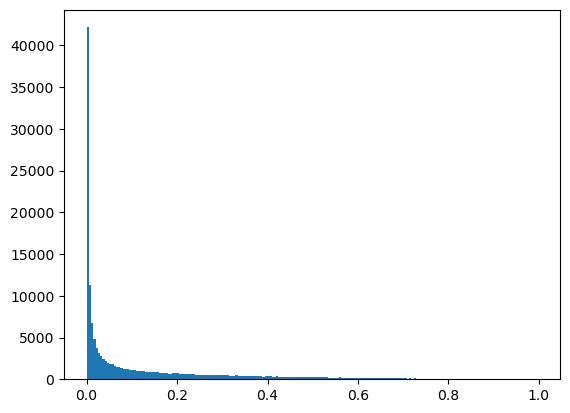

In [68]:
plt.hist(out_3.prob, bins=200)

In [73]:
out_3[out_3.prob>0.5]

,molecule,species,model,prob
53,CC(=O)OC12COC1CC(O)C1(C)C(=O)C(O)C3=C(C)C(OC(=...,Trigonostemon reidioides,both_known,0.703298
54,COC(=O)c1cc(OC)c(O)c(OC)c1,Trigonostemon reidioides,both_known,0.707943
84,C=C1CC23CCC4C(CO)(CO)CC(O)CC4(C)C2CCC1C3,Trigonostemon reidioides,both_known,0.698295
121,CC1=CCC(C(C)C2CCC3(C)C4CC(O)C5C(C)(C)OC(=O)C=C...,Trigonostemon reidioides,both_known,0.637167
153,CC1C(=O)CCC2C1(C)CCC1C2(C)CCC2(C)C3CC(C)(CO)CC...,Trigonostemon reidioides,both_known,0.901262
...,...,...,...,...
147609,CC1=C2CC(C(C)(C)O)CCC2(C)CCC1,Trigonostemon reidioides,both_known,0.733573
147610,CC1=CC2C(CC1)C(C)=CCCC2(C)C,Trigonostemon reidioides,both_known,0.849084
147651,COc1cc2c(c(OC)c1C(C)C)CCC1C2(C)CCC(O)C1(C)C,Trigonostemon reidioides,both_known,0.659104
147692,O=C1c2ccccc2C(=O)c2c(O)cccc21,Trigonostemon reidioides,both_known,0.696330


# Test 4: let's see if cholesterol is present "everywhere"


In [19]:
mol = 'CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C'
data_4 = pd.DataFrame(
    {'molecule': mol,
     'species': list(set(species_features_dummy.index)-set(sku[sku.structure_smiles_2D==mol].organism_name))})

In [20]:
data_4

,molecule,species
0,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Ascochyta pisi
1,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Conocybe siliginea
2,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Fraxinus insularis
3,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Salvia uliginosa
4,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Senegalia torta
...,...,...
35925,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Cystoseira foeniculacea
35926,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Nodulisporium
35927,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Clerodendrum phlomidis
35928,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Amanita porphyria


In [22]:
out_4 = predict(g_lotus, model_m_to_s, model_s_to_m,
                data_4,
                molecule_features_dummy,
                species_features_dummy
               )

Checking which model should be used for each row...
Adding missing nodes to the graph...
Converting NetworkX to Stellargraph...
StellarDiGraph: Directed multigraph
 Nodes: 184194, Edges: 869484

 Node types:
  molecule: [147747]
    Features: float32 vector, length 1051
    Edge types: molecule-present_in->species
  species: [36447]
    Features: float32 vector, length 69
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [434742]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [434742]
        Weights: all 1 (default)
        Features: none
Creating 'forward', 'backward' flow for KNOWN molecule AND species...
Predict both : running 'forward' predictions
36/36 [==============================] - 6s 162ms/step
Predict both : running backward prediction...
36/36 [==============================] - 6s 165ms/step


(array([  13.,   22.,   27.,   17.,   24.,   26.,   24.,   15.,   14.,
           9.,   16.,   10.,   11.,   14.,   28.,   15.,   20.,   19.,
          15.,   17.,   21.,   24.,   16.,   19.,   25.,   31.,   21.,
          22.,   21.,   15.,   25.,   28.,   36.,   31.,   46.,   35.,
          36.,   30.,   39.,   28.,   35.,   35.,   41.,   42.,   31.,
          25.,   37.,   42.,   34.,   34.,   37.,   37.,   42.,   43.,
          48.,   37.,   47.,   29.,   34.,   48.,   56.,   41.,   40.,
          58.,   50.,   52.,   48.,   57.,   52.,   65.,   50.,   67.,
          77.,   81.,   53.,   82.,   75.,   52.,   73.,   69.,   94.,
          84.,   80.,   88.,   95.,   87.,   91.,   97.,  121.,  104.,
         122.,  109.,  134.,  113.,  106.,  135.,  125.,  124.,  141.,
         136.,  163.,  121.,  140.,  146.,  168.,  145.,  128.,  148.,
         156.,  149.,  151.,  146.,  133.,  177.,  142.,  136.,  164.,
         153.,  166.,  152.,  150.,  150.,  133.,  150.,  185.,  183.,
      

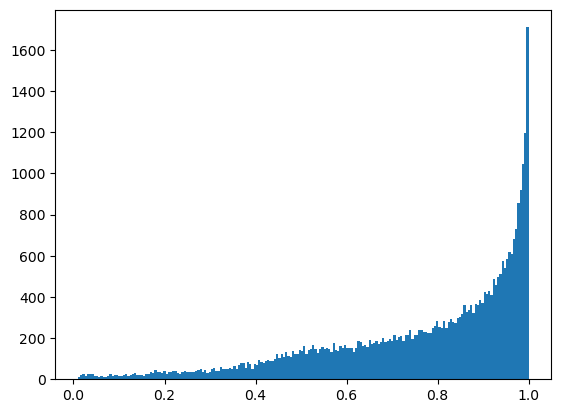

In [23]:
plt.hist(out_4.prob, bins=200)

In [24]:
len(out_4[out_4.prob>0.5])/len(out_4)

0.8630670748677985

In [25]:
out_4[out_4.prob>0.95]

,molecule,species,model,prob
0,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Ascochyta pisi,both_known,0.991290
1,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Conocybe siliginea,both_known,0.987356
12,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Callistemon linearis,both_known,0.980556
13,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Drimia maritima,both_known,0.980347
15,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Tabernaemontana markgrafiana,both_known,0.984435
...,...,...,...,...
35912,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Cyathus pygmaeus,both_known,0.979747
35913,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Artocarpus nitidus,both_known,0.961931
35916,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Calypogeia muelleriana,both_known,0.990520
35926,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,Nodulisporium,both_known,0.978375


# Test 5: test with a more rare molecule 

In [60]:
mol = 'CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(OC2OC(C)CC(N(C)C)C2O)C(C)(O)CC(C)C(=O)C(C)C(O)C1(C)O'
data_5 = pd.DataFrame(
    {'molecule': mol,
     'species': list(set(species_features_dummy.index)-set(sku[sku.structure_smiles_2D==mol].organism_name))}
)

In [61]:
out_5 = predict(g_lotus, model_m_to_s, model_s_to_m,
                data_5,
                molecule_features_dummy,
                species_features_dummy
               )

Checking which model should be used for each row...
Adding missing nodes to the graph...
Converting NetworkX to Stellargraph...
StellarDiGraph: Directed multigraph
 Nodes: 184194, Edges: 869484

 Node types:
  molecule: [147747]
    Features: float32 vector, length 1051
    Edge types: molecule-present_in->species
  species: [36447]
    Features: float32 vector, length 69
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [434742]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [434742]
        Weights: all 1 (default)
        Features: none
Creating 'forward', 'backward' flow for KNOWN molecule AND species...
Predict both : running 'forward' predictions
36/36 [==============================] - 7s 166ms/step
Predict both : running backward prediction...
36/36 [==============================] - 6s 170ms/step


(array([3.1717e+04, 6.8800e+02, 4.0200e+02, 2.9000e+02, 1.9200e+02,
        1.6700e+02, 1.4700e+02, 1.0700e+02, 1.1900e+02, 9.3000e+01,
        9.6000e+01, 7.0000e+01, 8.2000e+01, 5.0000e+01, 6.4000e+01,
        5.4000e+01, 5.5000e+01, 4.6000e+01, 4.7000e+01, 4.2000e+01,
        4.7000e+01, 4.4000e+01, 5.1000e+01, 3.6000e+01, 3.7000e+01,
        4.3000e+01, 3.6000e+01, 3.0000e+01, 3.5000e+01, 3.5000e+01,
        2.6000e+01, 2.8000e+01, 2.8000e+01, 3.6000e+01, 2.7000e+01,
        4.0000e+01, 2.2000e+01, 1.6000e+01, 2.9000e+01, 2.9000e+01,
        2.1000e+01, 2.5000e+01, 2.5000e+01, 1.5000e+01, 1.6000e+01,
        1.8000e+01, 2.2000e+01, 1.6000e+01, 1.3000e+01, 1.2000e+01,
        1.5000e+01, 1.6000e+01, 9.0000e+00, 2.0000e+01, 1.5000e+01,
        1.4000e+01, 1.4000e+01, 1.3000e+01, 8.0000e+00, 1.1000e+01,
        1.5000e+01, 1.3000e+01, 1.4000e+01, 1.1000e+01, 1.0000e+01,
        4.0000e+00, 1.4000e+01, 8.0000e+00, 1.1000e+01, 4.0000e+00,
        7.0000e+00, 6.0000e+00, 9.0000e+00, 9.00

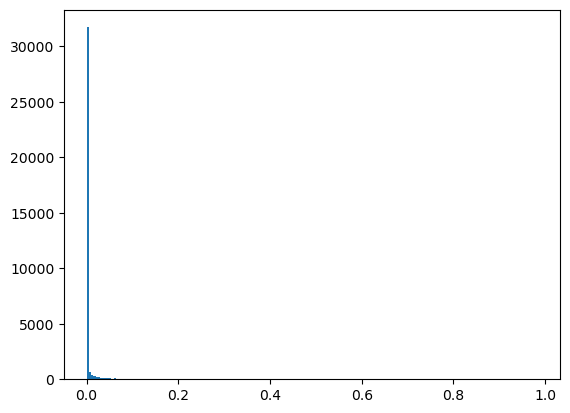

In [62]:
plt.hist(out_5.prob, bins=200)

In [63]:
out_5[out_5.prob>0.95]

,molecule,species,model,prob
286,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Streptomyces griseoruber,both_known,0.951896
1572,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Streptomyces violaceoruber,both_known,0.950047
2659,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Streptomyces argillaceus,both_known,0.983539
4233,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Streptomyces halstedii,both_known,0.950813
7464,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Streptomyces collinus,both_known,0.956449
7580,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Streptomyces ambofaciens,both_known,0.968695
9788,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Streptomyces lusitanus,both_known,0.956079
10470,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Streptomyces chattanoogensis,both_known,0.964442
10923,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Streptomyces bottropensis,both_known,0.950696
12822,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,Streptomyces,both_known,0.954166


148190